In [2]:
from scipy import stats
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
RESULT_DIR = '../../results/correlation-tests/'
PREFIX_DIR = os.path.join(RESULT_DIR, 'prefix-alignment')
HMMCONF_DIR = os.path.join(RESULT_DIR, 'hmmconf.rand_init')
PATT_DIR = os.path.join(RESULT_DIR, 'pattern')

In [6]:
prefix_df_list = []

for fname in os.listdir(PREFIX_DIR):
    if not fname.endswith('.csv'):
        continue
    fp = os.path.join(PREFIX_DIR, fname)
    df = pd.read_csv(fp)
    df['log'] = fname.replace('.csv', '')
    prefix_df_list.append(df)
    
prefix_df = pd.concat(prefix_df_list)

hmm_df_list = []

for fname in os.listdir(HMMCONF_DIR):
    if not fname.endswith('.csv'):
        continue
    fp = os.path.join(HMMCONF_DIR, fname)
    df = pd.read_csv(fp)
    df['log'] = df['log'].str.replace('.csv', '')
    hmm_df_list.append(df)

hmm_df = pd.concat(hmm_df_list)

patt_df_list = []

for fname in os.listdir(PATT_DIR):
    if not fname.endswith('.csv'):
        continue
    fp = os.path.join(PATT_DIR, fname)
    df = pd.read_csv(fp, sep='\t')
    df['log'] = fname.replace('.csv', '')
    patt_df_list.append(df)

patt_df = pd.concat(patt_df_list)
patt_df.rename(columns={
    'T:concept:name': 'caseid',
    'E:concept:name': 'activity'
}, inplace=True)

# create case_length
patt_df['tmp'] = 1
patt_df['case_length'] = patt_df[['caseid', 'log', 'tmp']].groupby(['log', 'caseid']).cumsum()
patt_df.drop(columns=['tmp'], inplace=True)

merged_df = pd.merge(prefix_df, patt_df, on=['log', 'caseid', 'case_length'])
merged_df = pd.merge(merged_df, hmm_df, on=['log', 'caseid', 'case_length'])

assert (merged_df['activity_x'] == merged_df['activity_y']).all()

merged_df.rename(columns={'activity_x': 'activity'}, inplace=True)
merged_df.drop(columns=['activity_y'], inplace=True)

# add model attributes
NET_DIR = '../../data/BPM2018/correlation-tests/models'
desc_fp = os.path.join(NET_DIR, 'description.csv')
desc_df = pd.read_csv(desc_fp)
get_netid = lambda s: s.replace('model_triangular_10_20_30_id_', '').replace('.pnml', '')
desc_df['net_id'] = desc_df['net'].apply(get_netid)

# add to merged_df
get_netid = lambda s: s.replace('log_model_triangular_10_20_30_id_', '').split('.pnml')[0]
merged_df['net_id'] = merged_df['log'].apply(get_netid)

merged_df = pd.merge(desc_df, merged_df, on='net_id')

### Make sure the data is consistent 

In [30]:
sort_order = ['log', 'caseid', 'case_length']
prefix_df = prefix_df.sort_values(sort_order).reset_index(drop=True)
hmm_df = hmm_df.sort_values(sort_order).reset_index(drop=True)
patt_df = patt_df.sort_values(sort_order).reset_index(drop=True)

assert prefix_df[sort_order].equals(hmm_df[sort_order])
assert patt_df[sort_order].equals(hmm_df[sort_order])

In [7]:
del hmm_df_list
del prefix_df_list
del patt_df_list

In [8]:
import time

start = time.time()
prefix_inc_cost_df = prefix_df.groupby(['log', 'caseid']).apply(lambda df: df['cost'].diff())
prefix_inc_cost_df = prefix_inc_cost_df.reset_index()
# prefix_inc_cost_df.cost.fillna(prefix_inc_cost_df['level_2'], inplace=True)
# prefix_inc_cost_df.drop(columns=['level_2'], inplace=True)
prefix_inc_cost_df.rename(columns={'cost': 'inc_cost'}, inplace=True)
prefix_inc_cost_df['tmp'] = 1
prefix_inc_cost_df['case_length'] = prefix_inc_cost_df[['log', 'caseid', 'tmp']].groupby(['log', 'caseid']).cumsum()
prefix_inc_cost_df.drop(columns=['tmp'], inplace=True)

took = time.time() - start
print('Took: {:.2f}s'.format(took))

Took: 97.95s


In [9]:
prefix_inc_cost_df.drop(columns=['level_2'], inplace=True)
merged_df = pd.merge(merged_df, prefix_inc_cost_df, on=['log', 'caseid', 'case_length'])

In [10]:
merged_df.inc_cost.fillna(merged_df['cost'], inplace=True)

In [11]:
merged_df.head()

,net,n_trans,n_places,n_arcs,n_inv,n_states,n_trans_rg,n_states_modified,n_trans_rg_modified,net_id,...,completeness,confidence,final_conformance,avg_final_conformance,sum_mode_distance,mode_completeness,sum_exp_distance,exp_completeness,sequence_likelihood,inc_cost
0,model_triangular_10_20_30_id_15.pnml,33,30,74,9,39,64,39,85,15,...,0.0,0.000000,0.866991,0.866991,0.0,1.0,0.000000,1.000000,0.105469,0.0
1,model_triangular_10_20_30_id_15.pnml,33,30,74,9,39,64,39,85,15,...,1.0,0.000000,1.000000,0.933496,0.0,1.0,0.019918,0.990143,0.046462,0.0
2,model_triangular_10_20_30_id_15.pnml,33,30,74,9,39,64,39,85,15,...,1.0,0.066667,1.000000,0.955664,0.0,1.0,0.019918,0.993406,0.046462,0.0
3,model_triangular_10_20_30_id_15.pnml,33,30,74,9,39,64,39,85,15,...,1.0,0.133333,1.000000,0.966748,0.0,1.0,0.019918,0.995046,0.046462,0.0
4,model_triangular_10_20_30_id_15.pnml,33,30,74,9,39,64,39,85,15,...,1.0,0.200000,1.000000,0.973398,0.0,1.0,0.019918,0.996033,0.046462,0.0


In [12]:
merged_df['inc_cost'].describe()

count    2.743834e+06
mean     6.895643e-02
std      2.533801e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: inc_cost, dtype: float64

### Correlation per net

In [24]:
desc_df

,net,n_trans,n_places,n_arcs,n_inv,n_states,n_trans_rg,n_states_modified,n_trans_rg_modified,net_id
0,model_triangular_10_20_30_id_15.pnml,33,30,74,9,39,64,39,85,15
1,model_triangular_10_20_30_id_8.pnml,32,27,70,9,29,44,29,51,8
2,model_triangular_10_20_30_id_27.pnml,32,32,76,9,70,146,70,186,27
3,model_triangular_10_20_30_id_14.pnml,23,18,48,6,19,29,19,31,14
4,model_triangular_10_20_30_id_43.pnml,34,27,76,10,31,57,31,65,43
5,model_triangular_10_20_30_id_32.pnml,26,23,56,4,124,372,124,411,32
6,model_triangular_10_20_30_id_50.pnml,28,30,66,9,389,1198,389,1754,50
7,model_triangular_10_20_30_id_12.pnml,14,12,32,2,17,33,17,35,12
8,model_triangular_10_20_30_id_26.pnml,33,37,78,10,133,329,133,374,26
9,model_triangular_10_20_30_id_49.pnml,31,27,68,10,51,112,51,137,49


In [13]:
merged_df['perc_inv'] = merged_df['n_inv'] / merged_df['n_trans']
grouped = merged_df.groupby(['net'])
grouped.apply(lambda df: stats.spearmanr(df.loc[(df['cost'] > 0) & (df['case_length'] > 1), 'cost'], df.loc[(df['cost'] > 0) & (df['case_length'] > 1), 'sum_mode_distance']))

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


net
model_triangular_10_20_30_id_12.pnml                              (nan, nan)
model_triangular_10_20_30_id_14.pnml                   (0.747544013822, 0.0)
model_triangular_10_20_30_id_15.pnml                   (0.550970657792, 0.0)
model_triangular_10_20_30_id_19.pnml    (-0.204172386286, 1.0654672968e-299)
model_triangular_10_20_30_id_26.pnml                   (0.266515298416, 0.0)
model_triangular_10_20_30_id_27.pnml                   (0.545902246141, 0.0)
model_triangular_10_20_30_id_32.pnml                   (0.732121489017, 0.0)
model_triangular_10_20_30_id_39.pnml                   (0.941680099071, 0.0)
model_triangular_10_20_30_id_43.pnml                   (0.450568147286, 0.0)
model_triangular_10_20_30_id_49.pnml                   (0.587775023282, 0.0)
model_triangular_10_20_30_id_8.pnml                    (0.721321356291, 0.0)
dtype: object

In [14]:
merged_df['perc_inv'] = merged_df['n_inv'] / merged_df['n_trans']
grouped = merged_df.groupby(['net'])
grouped.apply(lambda df: stats.spearmanr(df.loc[(df['cost'] > 0), 'cost'], df.loc[(df['cost'] > 0), 'sum_mode_distance']))

net
model_triangular_10_20_30_id_12.pnml                              (nan, nan)
model_triangular_10_20_30_id_14.pnml                   (0.741872710985, 0.0)
model_triangular_10_20_30_id_15.pnml                   (0.667692698481, 0.0)
model_triangular_10_20_30_id_19.pnml    (0.0917992415669, 1.20723558305e-69)
model_triangular_10_20_30_id_26.pnml                   (0.472144729496, 0.0)
model_triangular_10_20_30_id_27.pnml                   (0.676233962524, 0.0)
model_triangular_10_20_30_id_32.pnml                   (0.790415652055, 0.0)
model_triangular_10_20_30_id_39.pnml                   (0.929254759192, 0.0)
model_triangular_10_20_30_id_43.pnml                   (0.486282025395, 0.0)
model_triangular_10_20_30_id_49.pnml                   (0.691617451156, 0.0)
model_triangular_10_20_30_id_8.pnml                    (0.737169801276, 0.0)
dtype: object

In [15]:
no_noise = merged_df['cost'] == 0
less_than_x = merged_df['sum_mode_distance'] == 2
merged_df.loc[no_noise & less_than_x, ['log', 'caseid', 'case_length']].reset_index().iloc[6, 1]

'log_model_triangular_10_20_30_id_15.pnml_noise_trace_0.1_noise_event_0.4'

In [16]:
no_noise = merged_df['cost'] == 0
case_length = merged_df['case_length'] > 0
conformance = merged_df['final_conformance'] > 0.99
avg_conf = merged_df['avg_final_conformance'] > 0.99
sum_dist = merged_df['sum_mode_distance'] == 0
merged_df.loc[no_noise & case_length & conformance & sum_dist, 'avg_final_conformance'].shape[0] / merged_df.loc[no_noise & case_length, :].shape[0]
# merged_df.loc[no_noise & case_length, 'sum_mode_distance'].describe()

0.5512021103991458

In [17]:
yes_noise = merged_df['cost'] > 0
sum_dist = merged_df['sum_mode_distance'] > 0
conformance = merged_df['final_conformance'] < 1
case_length = merged_df['case_length'] > 0
merged_df.loc[yes_noise & case_length & (conformance | sum_dist), 'final_conformance'].shape[0] / merged_df.loc[yes_noise & case_length, :].shape[0]

0.9929225748090352

In [18]:
yes_noise = merged_df['cost'] > 0
sum_dist = merged_df['sum_mode_distance'] > 0
conformance = merged_df['final_conformance'] < 1
case_length = merged_df['case_length'] > 0
# merged_df.loc[no_noise & case_length & (conformance | sum_dist), ['log', 'caseid', 'case_length']]

### Spearman correlation with all results

In [19]:
noisy = merged_df['cost'] > -1

filtered_df = merged_df.loc[noisy, :]
rho_conf = stats.spearmanr(filtered_df['cost'], filtered_df['final_conformance'])
rho_mean_conf = stats.spearmanr(filtered_df['cost'], filtered_df['avg_final_conformance'])
rho_exp_dist = stats.spearmanr(filtered_df['cost'], filtered_df['sum_exp_distance'])
rho_exp_comp = stats.spearmanr(filtered_df['cost'], filtered_df['exp_completeness'])
rho_mode_dist = stats.spearmanr(filtered_df['cost'], filtered_df['sum_mode_distance'])
rho_mode_comp = stats.spearmanr(filtered_df['cost'], filtered_df['mode_completeness'])

print(
    'Final conformance: {}'.format(rho_conf),
    '\nMean conformance: {}'.format(rho_mean_conf), 
    '\nSum exp distance: {}'.format(rho_exp_dist),
    '\nExp completeness: {}'.format(rho_exp_comp),
    '\nSum mode distance: {}'.format(rho_mode_dist),
    '\nMode completeness: {}'.format(rho_mode_comp)
)

Final conformance: SpearmanrResult(correlation=-0.14456233373099106, pvalue=0.0) 
Mean conformance: SpearmanrResult(correlation=-0.56639288959354261, pvalue=0.0) 
Sum exp distance: SpearmanrResult(correlation=0.47125755240812656, pvalue=0.0) 
Exp completeness: SpearmanrResult(correlation=-0.49036610470614633, pvalue=0.0) 
Sum mode distance: SpearmanrResult(correlation=0.66345900133278313, pvalue=0.0) 
Mode completeness: SpearmanrResult(correlation=-0.68333269608683322, pvalue=0.0)


### Spearman correlation with non-conforming results

In [20]:
noisy = merged_df['cost'] > 0
case_length = merged_df['case_length'] > 0

filtered_df = merged_df.loc[noisy & case_length, :]
rho_conf = stats.spearmanr(filtered_df['cost'], filtered_df['final_conformance'])
rho_mean_conf = stats.spearmanr(filtered_df['cost'], filtered_df['avg_final_conformance'])
rho_exp_dist = stats.spearmanr(filtered_df['cost'], filtered_df['sum_exp_distance'])
rho_exp_comp = stats.spearmanr(filtered_df['cost'], filtered_df['exp_completeness'])
rho_mode_dist = stats.spearmanr(filtered_df['cost'], filtered_df['sum_mode_distance'])
rho_mode_comp = stats.spearmanr(filtered_df['cost'], filtered_df['mode_completeness'])

print(
    'Final conformance: {}'.format(rho_conf),
    '\nMean conformance: {}'.format(rho_mean_conf), 
    '\nSum exp distance: {}'.format(rho_exp_dist),
    '\nExp completeness: {}'.format(rho_exp_comp),
    '\nSum mode distance: {}'.format(rho_mode_dist),
    '\nMode completeness: {}'.format(rho_mode_comp)
)

Final conformance: SpearmanrResult(correlation=0.20336194767794769, pvalue=0.0) 
Mean conformance: SpearmanrResult(correlation=0.30885022780013943, pvalue=0.0) 
Sum exp distance: SpearmanrResult(correlation=0.76645064989050382, pvalue=0.0) 
Exp completeness: SpearmanrResult(correlation=-0.54663800768157045, pvalue=0.0) 
Sum mode distance: SpearmanrResult(correlation=0.78742282764147098, pvalue=0.0) 
Mode completeness: SpearmanrResult(correlation=-0.6059057618611875, pvalue=0.0)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


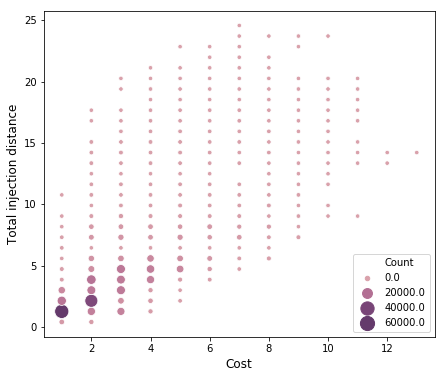

In [22]:
noisy = merged_df['cost'] > 0
case_length = merged_df['case_length'] >= 1
is_net = merged_df['net_id'] == '27'
scatter_df = merged_df.loc[noisy & case_length, :]

cost_var = 'cost'
var = 'sum_mode_distance'
_min = scatter_df[var].min()
_max = scatter_df[var].max()
bins = np.linspace(_min, _max, 30)
scatter_df['binned'] = pd.cut(scatter_df[var], bins=bins)
grouped = scatter_df[[cost_var, 'binned', 'caseid']].groupby([cost_var, 'binned'])
bubble_df = grouped.count().reset_index(drop=False)
bubble_df[var] = bubble_df['binned'].apply(lambda interval: (interval.left + interval.right) / 2)
bubble_df.rename(columns={'caseid': 'Count'}, inplace=True)

fig, ax = plt.subplots(figsize=(7, 6))
cmap = sns.cubehelix_palette(dark=.3, light=.7, as_cmap=True)

g = sns.scatterplot(x=cost_var, y=var,
               hue='Count', size='Count',
               sizes=(20, 200), palette=cmap,
               data=bubble_df, ax=ax)

_ = ax.set_xlabel('Cost', size=12)
_ = ax.set_ylabel('Total injection distance', size=12)
# _ = ax.set_title('Bubble plot of noisy non-first event instances for {}'.format(var))

outdir = './images/svg/'
if not os.path.isdir(outdir):
    os.makedirs(outdir)

out_fp = os.path.join(outdir, 'cost-injection-unconform-bubble.svg')
fig.savefig(out_fp, bbox_inches='tight', rasterized=True)

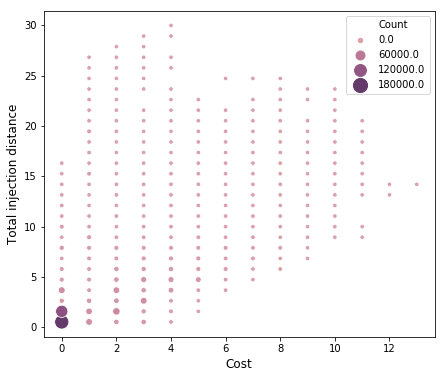

In [175]:
noisy = merged_df['cost'] > -1
case_length = merged_df['case_length'] >= 1
is_net = merged_df['net_id'] == '50'
scatter_df = merged_df.loc[noisy & case_length, :]

cost_var = 'cost'
var = 'sum_mode_distance'
_min = scatter_df[var].min()
_max = scatter_df[var].max()
bins = np.linspace(_min, _max, 30)
scatter_df['binned'] = pd.cut(scatter_df[var], bins=bins)
grouped = scatter_df[[cost_var, 'binned', 'caseid']].groupby([cost_var, 'binned'])
bubble_df = grouped.count().reset_index(drop=False)
bubble_df[var] = bubble_df['binned'].apply(lambda interval: (interval.left + interval.right) / 2)
bubble_df.rename(columns={'caseid': 'Count'}, inplace=True)

fig, ax = plt.subplots(figsize=(7, 6))
cmap = sns.cubehelix_palette(dark=.3, light=.7, as_cmap=True)

sns.scatterplot(x=cost_var, y=var,
               hue='Count', size='Count',
               sizes=(20, 200), palette=cmap,
               data=bubble_df, ax=ax)

_ = ax.set_xlabel('Cost', size=12)
_ = ax.set_ylabel('Total injection distance', size=12)
# _ = ax.set_title('Bubble plot of noisy non-first event instances for {}'.format(var))

outdir = './images/svg/'
if not os.path.isdir(outdir):
    os.makedirs(outdir)

out_fp = os.path.join(outdir, 'cost-injection-all-bubble.svg')
fig.savefig(out_fp, bbox_inches='tight', rasterized=True)

### Confusion matrix for fitting categorization

In [23]:
y_true = merged_df['cost'] == 0
y_pred = (merged_df['final_conformance'] > 0.99) & (merged_df['sum_mode_distance'] == 0)

from sklearn.metrics import confusion_matrix

cnf_mat = confusion_matrix(y_true, y_pred)
precision = cnf_mat[1, 1] / cnf_mat[:, 1].sum()
recall = cnf_mat[1, 1] / cnf_mat[1, :].sum()

print('Confusion matrix: \n{}\nPrecision: {:.5f}, Recall: {:.5f}'.format(cnf_mat, precision, recall))
print('True negatives: {}, True positives: {}, Predicted negatives: {}, Predicted positives: {}'.format(cnf_mat[0, :].sum(), cnf_mat[1, :].sum(), 
                                                                                                       cnf_mat[:, 0].sum(), cnf_mat[:, 1].sum()))


Confusion matrix: 
[[ 437115    8386]
 [1031487 1266846]]
Precision: 0.99342, Recall: 0.55120
True negatives: 445501, True positives: 2298333, Predicted negatives: 1468602, Predicted positives: 1275232


In [344]:
stats.spearmanr(merged_df['avg_final_conformance'], merged_df['case_length'])

SpearmanrResult(correlation=-0.15357684049985865, pvalue=0.0)

In [343]:
noise = merged_df['cost'] == 2
case_length = merged_df['case_length'] == 2
dist = merged_df['sum_mode_distance'] > 20
merged_df.loc[noise & dist, ['log', 'caseid', 'case_length', 'sum_mode_distance']].head()

,log,caseid,case_length,sum_mode_distance
481525,log_model_triangular_10_20_30_id_27.pnml_noise...,929,7,21.5
481526,log_model_triangular_10_20_30_id_27.pnml_noise...,929,8,23.5
481527,log_model_triangular_10_20_30_id_27.pnml_noise...,929,9,23.5
481528,log_model_triangular_10_20_30_id_27.pnml_noise...,929,10,23.5
481529,log_model_triangular_10_20_30_id_27.pnml_noise...,929,11,23.5


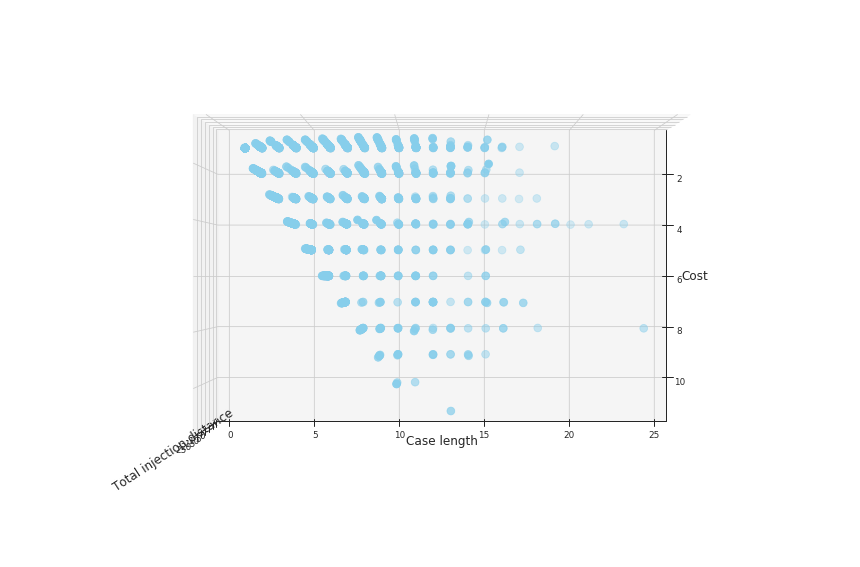

In [334]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Dataset
df=pd.DataFrame({'X': range(1,101), 'Y': np.random.randn(100)*15+range(1,101), 'Z': (np.random.randn(100)*15+range(1,101))*2 })

yes_noise = merged_df['cost'] > 0
case_length = merged_df['case_length'] > 0
shuffled_df = merged_df.loc[yes_noise & case_length, :].sample(frac=0.01)
X = shuffled_df['cost']
Y = shuffled_df['case_length']
Z = shuffled_df['sum_mode_distance']

# plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c='skyblue', s=60)
ax.view_init(90, 0)

ax.set_xlabel('Cost', fontsize=12)
ax.set_ylabel('Case length', fontsize=12)
ax.set_zlabel('Total injection distance', fontsize=12)
plt.show()

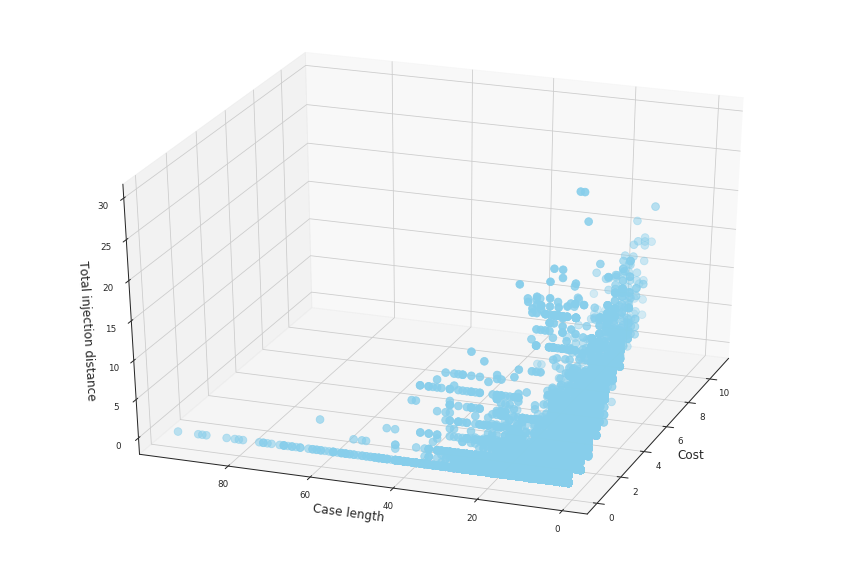

In [278]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

shuffled_df = merged_df.sample(frac=0.01)
X = shuffled_df['cost']
Y = shuffled_df['case_length']
Z = shuffled_df['sum_mode_distance']

# plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c='skyblue', s=60)
ax.view_init(30, 200)

ax.set_xlabel('Cost', fontsize=12)
ax.set_ylabel('Case length', fontsize=12)
ax.set_zlabel('Total injection distance', fontsize=12)
plt.show()